<h1> Wine Classification using a K-Nearest Neighbours Algorithm </h1>

This is another in a series of practice projects I undertook while learning different machine learning algorithms with Codecademy. In these projects, I've used various toy data sets provided by the scikit-learn folks to make sure I understood how to implement the algorithms I've learned. For this project, I wanted to practice implementing a K-Nearest Neighbours (KNN) algorithm to classify wines in scikit-learn's wine recognition data set. As I understand it, the basic idea behind the KNN algorithm is that things with similar classifications tend to have similar properties, and so if one looks at the <i>k</i> "nearest neighbours" (in terms of some distance calculation) of a data point one can classify it based on the classifications of its neighbours. Since the wine recognition data set consists of chemical analysis data, the idea of a "distance" between data points is fairly well defined, so this seems an ideal data set to practice implementing a KNN algorithm on. The main idea is that I'll be able to classify wines based on the results of chemical analysis done on them.

From the documentation provided by the scikit-learn folks, I've been able to learn that the data in the wine recognition data set comes from three different kinds of wine that were made from grapes grown in the same region in Italy. Thirteen different measurements were conducted on samples of the three different types of wine, and the results were compiled into the data set I will be using. I also learned that there were three different grape cultivators whose grapes contributed to the wines, so I assume there will be some variation in the chemical analysis results due to variations in local growing conditions and/or local water profiles. The documentation doesn't go into the specifics of which kinds of wine were chosen for inclusion in the data set (i.e., were they all merlots from different vineyards, or were there a mix of red wines and white wines, etc.), so I don't have a tremendous amount of insight there.

Before I dive into building the KNN model, I should give some credit to the folks who compiled the data set I'm about to use and to the scikit-learn folks who made it available through their open-source software package.<br>
Let's start with a citation to the scikit-learn folks: <br>
Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011 <br>
and, of course, their main website: https://scikit-learn.org/stable/index.html.<br>
The original owners of the data set were:<br>
Forina, M. et al, PARVUS - An Extendible Package for Data Exploration, Classification and Correlation. <br>
Institute of Pharmaceutical and Food Analysis and Technologies, Via Brigata Salerno, 16147 Genoa, Italy.<br>
And the scikit-learn folks cited the following data set repository:<br>
Lichman, M. (2013). UCI Machine Learning Repository <br>
[https://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.<br>

<h1> Importing the data set and packages to be used </h1>

In [1]:
# First, import the data set:
from sklearn.datasets import load_wine

# Next, import packages which will help me analyze and visualize the data:
import pandas as pd
import matplotlib.pyplot as plt

# And finally, the packages which will let me build a KNN model:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Now I need to actually load the imported data set. The default when one loads a Scikit-Learn data set seems to be an 
# object called a "bunch," although for this data set there is an option to import as a DataFrame so I will use that:

wine_data = load_wine(as_frame = True)  

In [3]:
# print(wine_data.DESCR)
# I printed out the file description to see what the various columns correspond to, and what the "targets" (i.e., 
# classifications) are. I was hoping there would be more information about what class_0, class_1, and class_2 are, 
# but that doesn't seem to be the case. Maybe they stand for red, white, and rose? I guess I would have to read 
# the cited papers to find out.
# At any rate, I've commented this call to print() out so as not to clog the output cell. 

# Separate out the "features" (i.e., measurements) as a DataFrame:
all_features = wine_data.data

# Make a Series for the "targets" (i.e., classifications):
targets = wine_data.target

Since I loaded the wine recognition data as a DataFrame, I don't need to convert all_features and targets to DataFrames; they already are DataFrames/Series. 

I infer that, in the target Series, 0 is class_0, 1 is class_1, and 2 is class_2. Interestingly, the data seems to be provided in numerical order by class. I don't think this will have an impact on the KNN algorithm, but it was interesting to note.

<h1> Normalizing the data and building the KNN model </h1>

I should normalize the data so that features whose scale is larger than that of others don't dominate the distance calculation in the KNN algorithm. Why is this so important, and what does it mean to normalize the data? Let's consider the proline measurements, which have a maximum of 1,680 and a minimum of 278; these values are on a very different scale than those of the hue measurements (which have a maximum of 1.71 and a minimum of 0.48). If I blindly let the KNN algorithm calculate the distance between data points, differences in proline measurements will dominate that calculation merely because they just so happen to have the largest measurement values. To ensure that all data have approximately the same scale, I will normalize the data before handing it over to the KNN algorithm. Here I'll be using a min/max normalization, which sets the minimum value of a feature to 0, the maximum value to 1, and anything in between as a value between 0 and 1; I'll also be doing the normalization calculation by hand for extra practice. (I know the scikit-learn preprocessing package has a MinMaxScaler that I could use.) I will normalize the data first, then split it into training, validation, and test sets.

In [4]:
# Here I normalize the data by doing a min/max scaling:
normed_all_features = (all_features - all_features.min())/(all_features.max()-all_features.min())

# And here I split the features and targets up into training, validation,  and test sets. I will use a split of 
# 70% training, 15% validation (to determine the optimal k), and 15% test. Also, I will pick a random state so 
# that I can keep the same splitting of feature rows/target rows each time I run the cells in this Jupyter Notebook.

# First, let me define some variables:
train_frac = 0.70 
valid_frac = 0.15
test_frac = 0.15
adj_valid_frac = valid_frac / (1 - test_frac)

# Now split the features and targets up into "nottest" and test sets:
feat_nottest_all, feat_test_all, class_nottest_all, class_test_all =  \
      train_test_split(normed_all_features, targets, test_size = test_frac, random_state = 42)

# 85% of the data was partitioned into the "nottest" data subset. Divide this data subset into the actual
# training and validation sets:
feat_train_all, feat_valid_all, class_train_all, class_valid_all = \
      train_test_split(feat_nottest_all, class_nottest_all, test_size = adj_valid_frac, random_state = 42)

Now to build a KNN model for the data. I don't know <i> a priori </i> how many nearest neighbours I should look at to best classify my data, so I will have that be a free parameter in my model. The criterion by which I will chose <i>k</i> (the number of nearest neighbours the algorithm uses for classification) is maximization of the model accuracy when the model is applied to the validation set. In other words, the <i>k</i> I chose will be the one which results in the highest accuracy. 

In [5]:
# an empty array to hold accuracy scores:
scores_all = []

# Loop over a range of ks and store the resulting model accuracy score:
for k in range(1,len(feat_train_all)+1):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(feat_train_all, class_train_all)
    scores_all.append(classifier.score(feat_valid_all, class_valid_all))

# print out the k which resulted in the model with the highest accuracy score:
print(scores_all.index(max(scores_all))+1)

5


It looks as though the <i>k</i> (i.e., number of nearest neighbours the algorithm uses in its classification) which yields the KNN model with the highest accuracy is 5.

Now that I've found the model with the highest accuracy (when I applied it to the validation set), I'll use it as "the" model by which I classify the wines in the test set (the portion of the data that was set aside from the rest of the data when I first called train_test_split() ). And since I know the true classification of each of those wines, I'll be able to see how well the model did and what it got wrong.

In [6]:
# First, build the KNN model with the k which results in the highest accuracy:
all_classifier = KNeighborsClassifier(n_neighbors = scores_all.index(max(scores_all))+1)
all_classifier.fit(feat_train_all, class_train_all)

# Ask that model to classify the wines in the test set, and print out what the model accuracy score is:
all_class_predictions = all_classifier.predict(feat_test_all)
all_classifier_score = all_classifier.score(feat_test_all, class_test_all)
print(all_classifier_score)

0.9629629629629629


My <i>k</i> = 5 KNN model has an accuracy score of 96.3%! This means it misclassifies only 3.7% of wines in the test set. That is an excellent accuracy score, so I think I've built a pretty good KNN model for this particular (toy) data set.

Since I have the information to do so, let's see how the accuracy score changed with the <i>k</i> considered:

Text(0.5, 1.0, 'Accuracy Score of Wine Recognition Data Set KNN models')

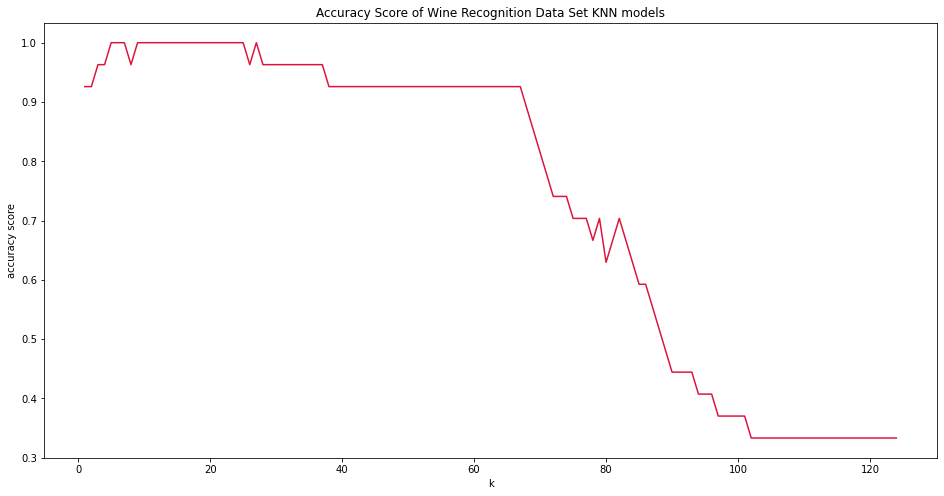

In [7]:
plt.figure(figsize=(16,8))
plt.plot(range(1,len(feat_train_all)+1),scores_all, color = 'crimson')
plt.ylabel('accuracy score')
plt.xlabel('k')
plt.title('Accuracy Score of Wine Recognition Data Set KNN models')

At least in general, the accuracy score follows the trend that I'd expect: it increases with inceasing <i>k</i>, reaches a maximum, then decreases as <i>k</i> continues to increase. It does surprise me that the accuacy score plateaus between roughly 40 and 70; I admit, I'm not 100% sure why this is. I imagine that it could be because the data set is relatively small, and so the validation set is also relatively small. Different random state initalizations would assign different wine samples to the training, validation, and test sets, and this might have an impact on how this plot turns out; with only 27 wine samples in the validation set, which I am judging accuracy based on, there would likely be fluctuations in this plot if different samples were randomly assigned to the validation set.

<h1> Visualizing the model's performance </h1>

Let's take a closer look at how my model did by building a couple of visualizations. The first visualization I will do is similar to the visualization I did for my logistic regression model for the data in scikit-learn's breast cancer data set; this visualization will be a bar graph which illustrates the number of classifications that the model got right, and the number of classifications it got wrong.

The number of successes was 26, and the number of failures was 1


Text(0.5, 1.0, 'Number of Successful and Failed Model Predictions')

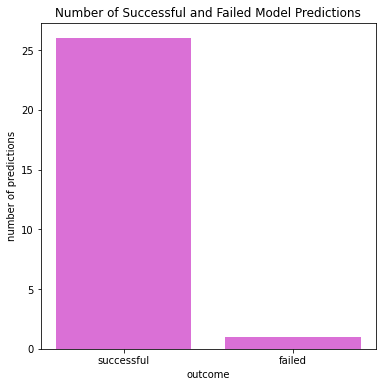

In [8]:
# An empty array:
results_all=[]

# Loop over wine samples to see if the predicted classfication and actual classification match up:
for i in range(len(all_class_predictions)):
    if all_class_predictions[i] == class_test_all.iloc[i]:
        results_all.append('successful')
    else:
        results_all.append('failed')

# Count the number of successes and the number of failures:
success_count_all = results_all.count('successful')
fails_count_all = results_all.count('failed')

# Set these success/failure counts up for a bar graph visualization. There are two options: The predicted
# classification was successful -- it matched the actual classification -- or it failed. Set up an array stating
# these options, and gather up the counts.
options = ['successful', 'failed']
test_counts_all =[success_count_all, fails_count_all]

# Print out the raw numbers, just so that I can see them:
print('The number of successes was {}, and the number of failures was {}'.format(success_count_all,fails_count_all))
     
# Now plot a histogram to visualize the success/failure counts:
plt.figure(figsize=(6,6))
plt.bar(options, test_counts_all, color = 'orchid')
plt.ylabel('number of predictions')
plt.xlabel('outcome')
plt.title('Number of Successful and Failed Model Predictions')

Now I will make a visualization that is similar to what I did for my Support Vector Machine (SVM) model for the data in scikit-learn's iris data set; this visualization will look at each wine sample in the test set, assign an "ID" to it which is just its index number in the set (i.e., 0 for the first wine sample, 1, for the second wine sample, etc.), and plot its true classification in red and the model predicted classification in blue. If the true and model classifications line up, the corresponding dot on the below plot will be purple. Otherwise, we will see separate red and blue dots where the model failed to get the classification right.

Text(0.5, 1.0, 'Actual Wine Classification Compared to Model Classification')

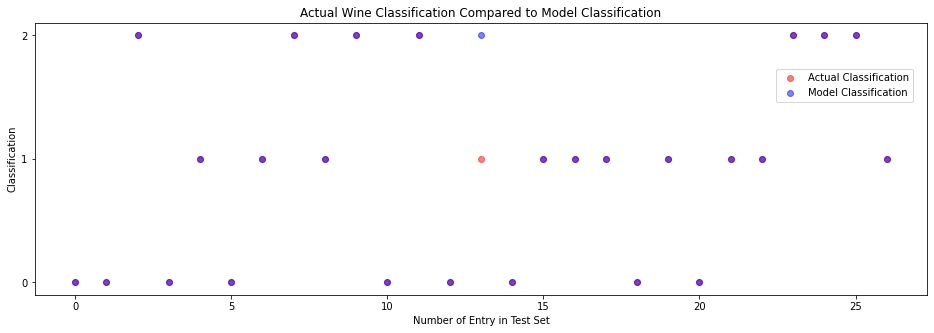

In [9]:
# Set up a horizontal axis which is just the "ID" number of the wine sample in the test set:
x_axis = range(len(class_test_all))

# Plot the true and model classifications. This is made possible due to the fact that the classifications were
# prrovided as numbers.
plt.figure(figsize=(16,5))
ax = plt.subplot()
plt.scatter(x_axis, class_test_all, color = 'red', alpha = 0.5)
plt.scatter(x_axis, all_class_predictions, color = 'blue', alpha = 0.5)
ax.set_yticks([0,1,2])
ax.set_yticklabels([0,1,2])
plt.legend(['Actual Classification', 'Model Classification'], bbox_to_anchor=(0.99, 0.85))
plt.xlabel('Number of Entry in Test Set')
plt.ylabel('Classification')
plt.title('Actual Wine Classification Compared to Model Classification')

What I like about this visualization is that it allows me to see precisely which wine samples were misclassified, what the true classification was, and what classification the model assigned to it. It's another great visual way to look at the model's performance.

<h1> Conclusions </h1> 

In this small project, based on the wine recognition toy data set in the scikit-learn datasets package, I implemented a K-Nearest Neighbours classification algorithm to classify wines on the basis of their chemical analysis measurements. This model proved to be very accurate, misclassifying only one wine sample out of 27. I plotted model accuracy score versus <i>k</i> to ensure that the trend of accuracy with <i>k</i> was roughly what I expected; I then constructed two graphs which helped me visualize the model's perforrmance. One of these graphs was just a bar graph of the number of successful classifications of the model and the number of failed classifications; the other plotted the true and model-assigned classifications of each wine sample in the test set to see which ones overlapped, and when they didn't what the true and model-assigned classifications were. All in all, for this particular data set, I conclude that a KNN algorithm does an excellent job in predicting wine classification. 